In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spacextoy-dataanalysis-launchprediction/data_falcon9.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_landing_failure.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex_landing_success.csv
/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex.csv


### Correlation
* Correlation is used to measure the linear association between two variables.
* Two variables which are linearly dependent will have a higher correlation than two variables which are non-linearly dependent.
* Features with high correlation (more linearly dependent) have almost the same effect on the dependent variable, and dropping one of the two features can improve analysis and prediction.

### Null Hypothesis
* A general statement that there is no relationship between two measured phenomena.
> * Testing (accepting, approving, rejecting, or disproving) the null hypothesis — and thus concluding that there are or are not grounds for believing that there is a relationship between two phenomena (e.g. that a potential treatment has a measurable effect) — is a central task in the modern practice of science; the field of statistics gives precise criteria for rejecting a null hypothesis.
[Wikipedia](https://en.wikipedia.org/wiki/Null_hypothesis)

### P-value
* P-value or probability value or asymptotic significance 
* [P-values are not ideal metrics for feature selection](https://stats.stackexchange.com/questions/291210/is-it-wrong-to-choose-features-based-on-p-value/291239#291239); however, p-values can be used to decide whether to keep a feature.
* The probability value for a given statistical model that, if the null hypothesis is true, the statistical summary is greater than or equal in magnitude to the observed results.
* P-value is used to accept of reject the null hypothesis.

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [106]:
# for reproducibility
np.random.seed(42)

In [107]:
# load the dataset
data = pd.read_csv("/kaggle/input/spacextoy-dataanalysis-launchprediction/spacex.csv")

In [110]:
data.columns

Index(['Class', 'FlightNumber', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'ReusedCore', 'Legs',
       'Block', 'ReusedCount', 'Serial', 'Year', 'ReusedFairings'],
      dtype='object')

In [109]:
# and change order to Class first
data = data[['Class','FlightNumber', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'ReusedCore', 'Legs',
       'Block', 'ReusedCount', 'Serial',
       'Year', 'ReusedFairings']]

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Class           90 non-null     int64  
 1   FlightNumber    90 non-null     int64  
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     int64  
 9   ReusedCore      90 non-null     int64  
 10  Legs            90 non-null     int64  
 11  Block           90 non-null     int64  
 12  ReusedCount     90 non-null     int64  
 13  Serial          90 non-null     object 
 14  Year            90 non-null     int64  
 15  ReusedFairings  90 non-null     int64  
dtypes: float64(1), int64(10), object(5)
memory usage: 11.4+ KB


In [ ]:
# Object/Categorical Data Types
# BoosterVersion, Orbit, LaunchSite, Outcome, Serial

In [112]:
# Encode target labels with value between 0 and n_classes-1
data = data.apply(LabelEncoder().fit_transform)

### Selection of Features Based on Correlation

<AxesSubplot:>

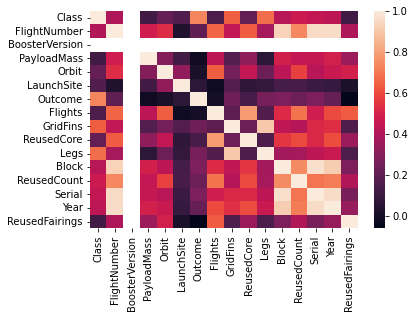

In [113]:
# correlation matrix
corr = data.corr()
# correlation heatmap
sns.heatmap(corr)

In [114]:
# compare the correlation between features 
# remove one of two features that have a correlation > 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [115]:
selected_columns = data.columns[columns]

In [116]:
selected_columns

Index(['Class', 'FlightNumber', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'ReusedCore',
       'ReusedCount', 'ReusedFairings'],
      dtype='object')

In [117]:
#Now, only those columns with correlation < 0.9
## Removed: > 0.9
# Block (with Year and Serial)
# Serial (with Year and Block)
# Legs (with GridFins)
# Year (with Serial and Block)
data = data[selected_columns]

### Selection of Features based on P-value
* Based on how they affect the p-value
* Remove the target value

In [118]:
# drop target variable
selected_columns = selected_columns[1:].values

In [119]:
import statsmodels.api as sm

[statsmodels](https://www.statsmodels.org/dev/index.html) is a module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

In [120]:
# assume the null hypothesis: “The selected combination 
# of dependent variables 
# do not 
# have any effect on the independent variable”
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        # build a small regression model
        regressor_OLS = sm.OLS(Y, x).fit()
        # calculate the p values
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                # If the p values is higher than the threshold, 
                # we discard that combination of features
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [121]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)

In [122]:
# move to a new dataframe
result = pd.DataFrame()
# add target back
result['Class'] = data.iloc[:,0]

In [123]:
# create dataframe with:
# columns selected using the p-value and correlation
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

### Visualize Features Selected

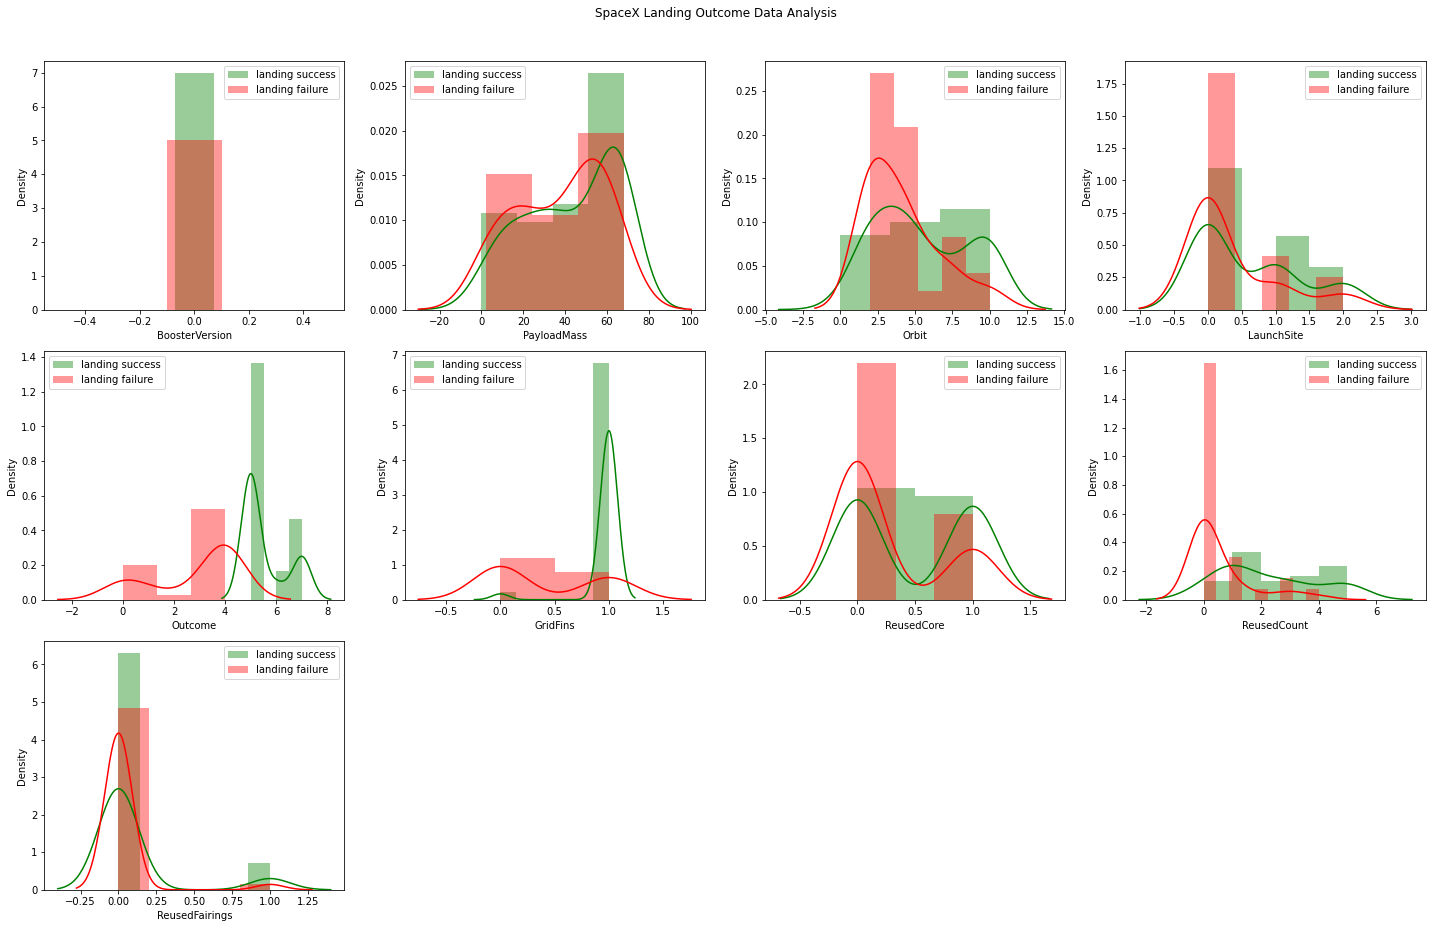

In [125]:
#visualize their distribution
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][result['Class']==1], color='g', label = 'landing success')
    sns.distplot(data[i][result['Class']==0], color='r', label = 'landing failure')
    plt.legend(loc='best')
fig.suptitle('SpaceX Landing Outcome Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Utilize the Features in a Model

In [126]:
x_train, x_test, y_train, y_test = train_test_split(data.values, result.values, test_size = 0.2)

In [128]:
from sklearn.model_selection import GridSearchCV

In [130]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),'C': np.logspace(-3, 3, 5),'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, param_grid = parameters, cv = 10)
svm_cv.fit(x_train, y_train)
print("tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 1.0


In [132]:
svm = SVC(C = 1.0, gamma = 0.001, kernel = 'linear').fit(x_train,y_train)
prediction = svm.predict(x_test)

In [134]:
confusion_matrix(y_test, prediction)

array([[ 4,  0],
       [ 0, 14]])

In [135]:
from sklearn.metrics import classification_report

In [136]:
print("Support Vector Machine Classification Report:\n", classification_report(y_test, prediction))

Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        14

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



### Sources
[Machine Learning - The Science, The Engineering, and The Ops](https://vishalramesh.substack.com/)